In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import NuestrasFunciones

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
    
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20, 12)

### Hice este trabajo con clases de transformadores custom para aprender a utilizarlos, me falta entender la trasnferencia de información entre fit y transform un poco mejor, en el próximo proyecto lo veré más a fondo.

In [2]:
df_fuga_sinObj = pd.read_csv("In/FugaClientes_Test.csv")
df_fuga = pd.read_csv("In/FugaClientes_Training.csv")

<Axes: >

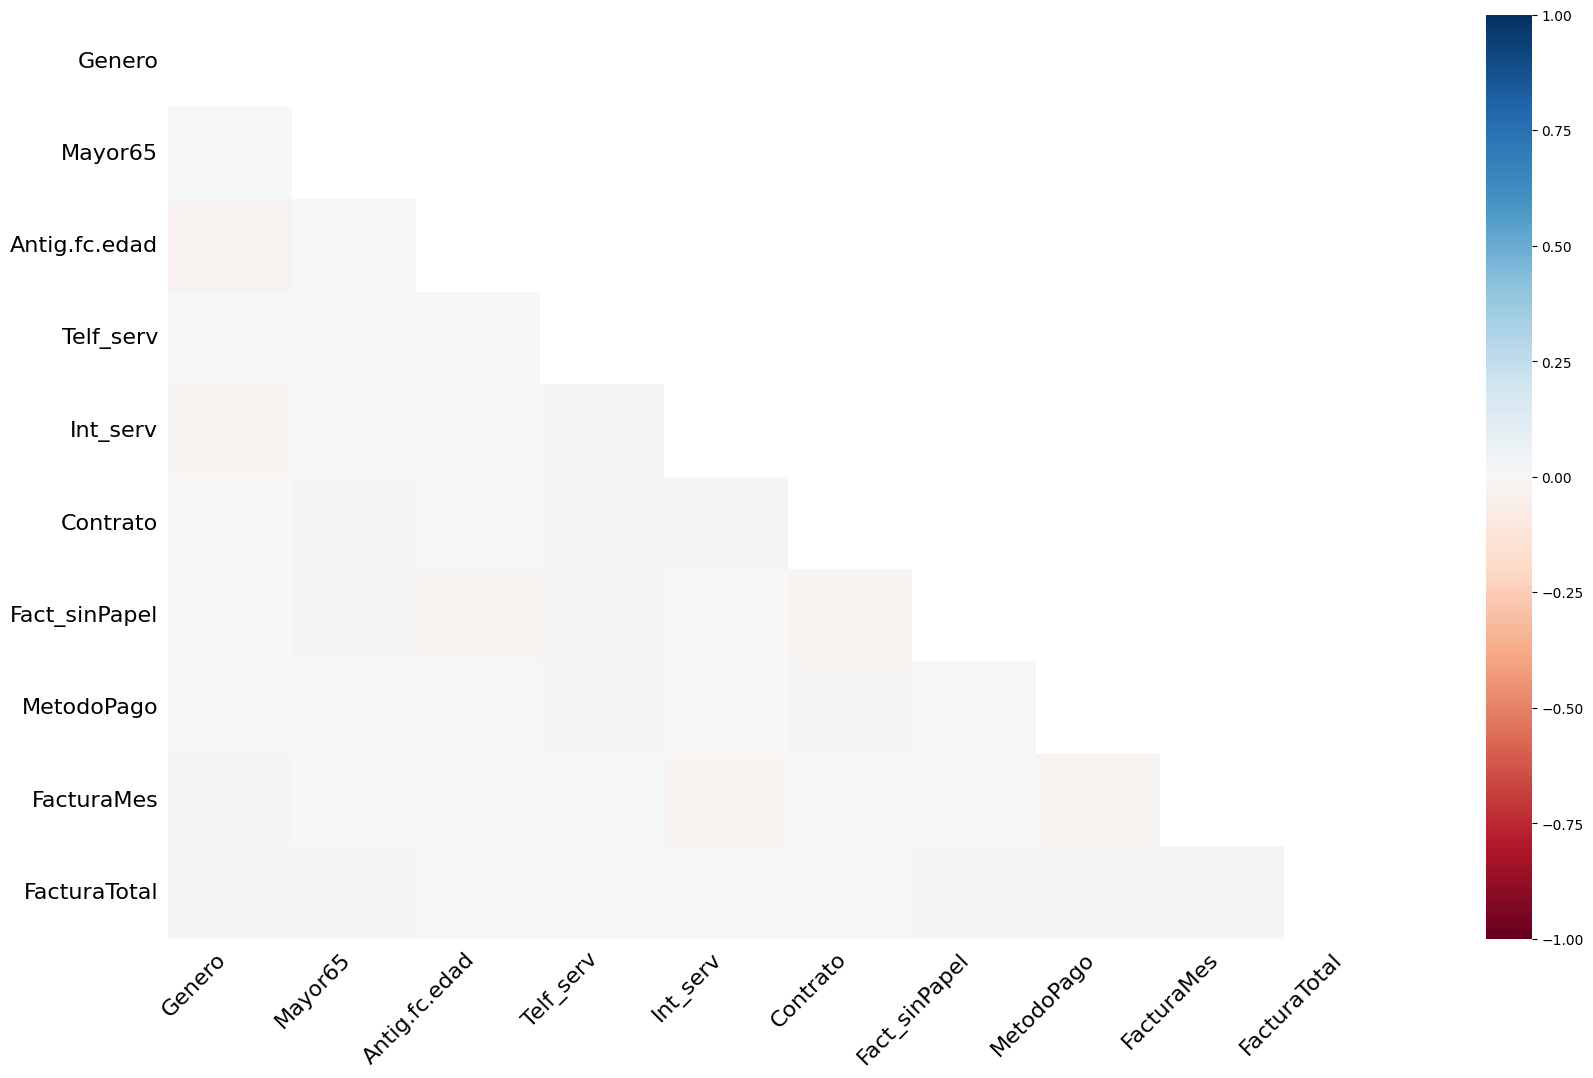

In [3]:
import missingno as msno 
msno.heatmap(df_fuga)

Cat


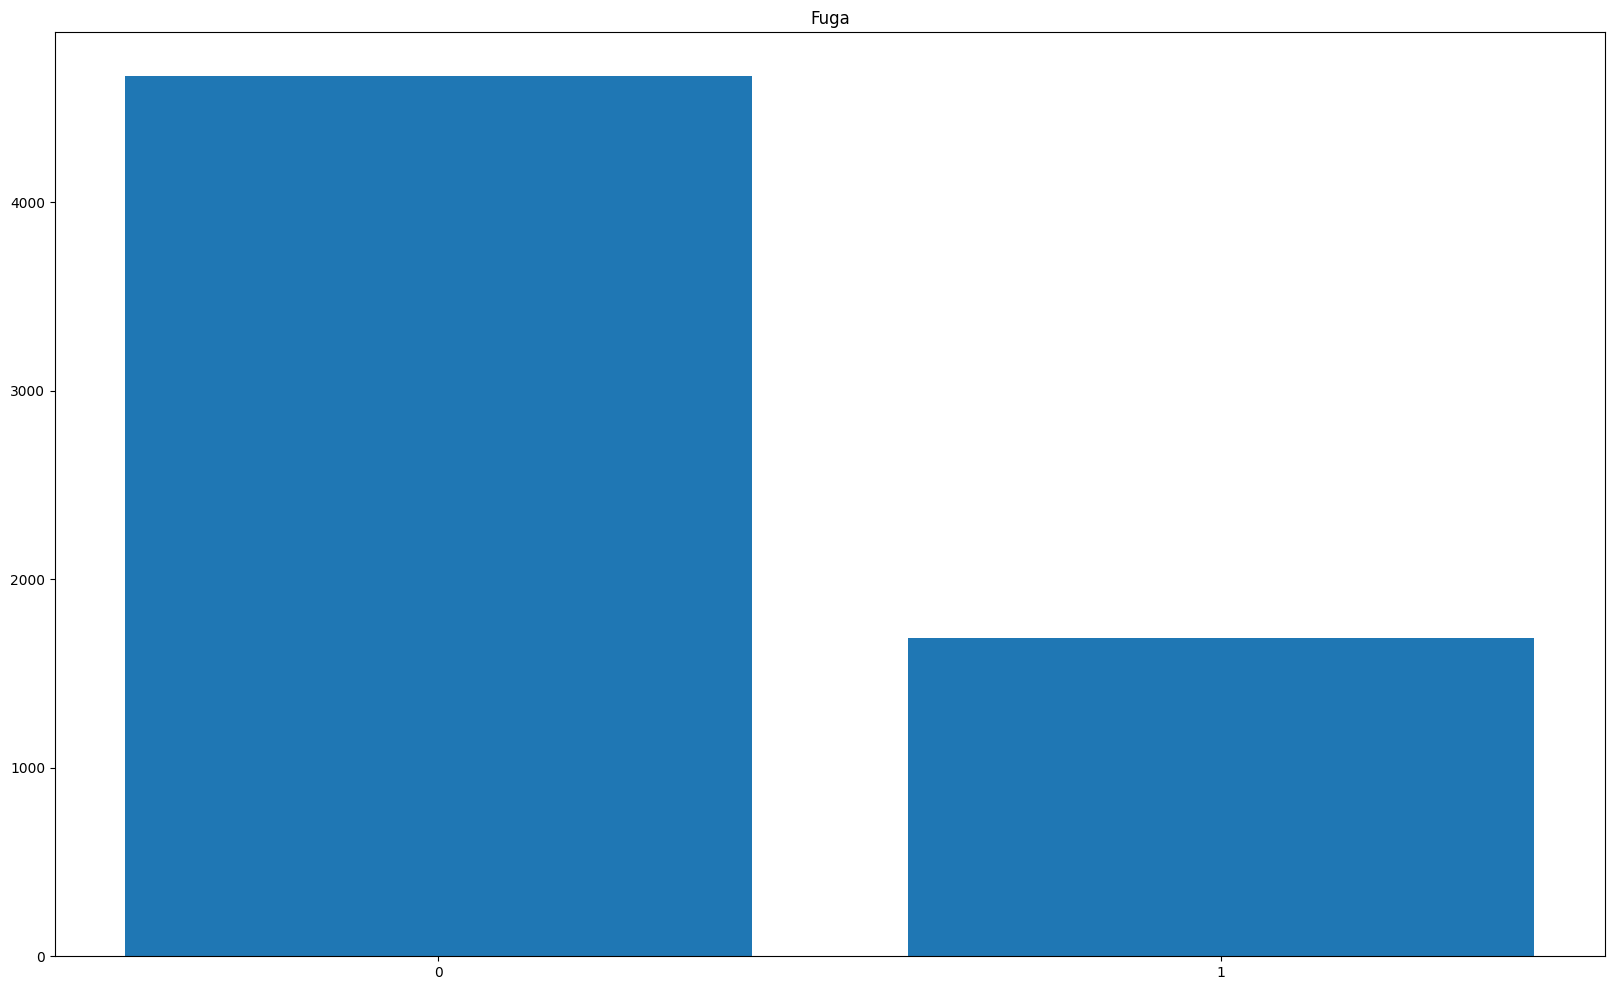

In [4]:
NuestrasFunciones.plot(df_fuga.Fuga.astype("category")) 

In [5]:
def columna_missing(df,tipo = "individual"):
    """
    si tipo individual crea una por variable que contenga missings, 
    si tipo agg crea una columna prop missings que indica proporcion de fila que es NA.
    """

    if tipo == "individual":
        #select_dtypes(include=np.number)
        for cols in df.columns:
            if df[cols].isnull().values.any():
                nombre = cols + "_esNA"
                df[nombre] = df[cols].apply(lambda x: 1 if pd.isnull(x) else 0)
    elif tipo == "agg":
        #df_fuga["proportion_missing"] = df_fuga.apply(lambda x: x.isna().sum() / x.size * 100, axis = 1)
        df["missing_count"] = df.apply(lambda x: x.isna().sum(), axis = 1)

def no_yes_dicotom(df):
    for col in df.columns:
        if set(df[col].value_counts().index).issuperset(["No", "Yes"]):
            df.loc[df[col] == "No", col] = 0 
            df.loc[df[col] == "Yes", col] = 1
        
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class Clenaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, tipo = "individual"): 
        self.tipo = tipo
        
    def fit(self, X, y=None):
        return self 
        
    def transform(self,X,y = None):
        X.rename(columns = {"Antig.fc.edad": "meses_antiguedad"},inplace = True)
        X.drop("ID",axis = 1,inplace = True)

        X.loc[X["Genero"] == "Male", "Genero"] = 0 
        X.loc[X["Genero"] == "Female", "Genero"] = 1
        
        no_yes_dicotom(X)
        columna_missing(X, tipo = "agg")
        
        to_factor = list(X.loc[:,X.nunique() <= 4]);  
        X[to_factor] = X[to_factor].astype('category')

        
        return X

In [6]:
df_fuga.columns

Index(['ID', 'Genero', 'Mayor65', 'Conyuge', 'PersCargo', 'Antig.fc.edad',
       'Telf_serv', 'VariasLineas', 'Int_serv', 'Seguridad', 'CopiaSeguridad',
       'Antivirus_disp', 'Soporte_tecnico', 'TV_streaming', 'Peliculas',
       'Contrato', 'Fact_sinPapel', 'MetodoPago', 'FacturaMes', 'FacturaTotal',
       'Fuga'],
      dtype='object')

In [7]:
def tipos(df, todos = False):
    X_dicotom = []
    X_cat = []
    X_cont = []
    
    for cols in df.columns:
        es_digito = df[cols].value_counts(dropna = True)
        es_digito = [True if np.issubdtype(type(x), np.number) else False for x in es_digito.index]
        if all(es_digito):
            if df[cols].nunique() <= 2:
                X_dicotom.append(cols)
            elif df[cols].nunique() > 2:
                X_cont.append(cols)
        else:
            X_cat.append(cols)
    if todos:
        return X_cont,X_cat,X_dicotom,df.columns
        
    else:
        return X_cont,X_cat,X_dicotom
                 
#uno,dos,tres = tipos(X)

class Imputador(BaseEstimator, TransformerMixin):



    def __init__(self, neighbors = False):
        self.neighbors = neighbors

    
    def fit(self, X, y=None):
        #print("hizo fit")
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.imputer_moda = skl_imp.SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.imputer_random = fe_imp.RandomSampleImputer()
        
        self.imputer_moda.fit(X[self.X_dicotom])
        self.imputer_random.fit(X[self.X_cat])

        
        return self 
    
    def transform(self, X, y=None):
        #print("una")
       # print(self.X_cat)
       # print("-------------------")
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.imputer_random.transform(X[self.X_cat])
        self.X_cat = pd.DataFrame(self.imputer_random.transform(X[self.X_cat]),columns = self.X_cat)#,columns = self.X_cat
        self.X_dicotom = pd.DataFrame(self.imputer_moda.transform(X[self.X_dicotom]),columns = self.X_dicotom)
        
        if self.neighbors:
            imputer_knn = skl_imp.KNNImputer(n_neighbors=self.neighbors)
            self.X_cont = pd.DataFrame(imputer_knn.fit_transform(X[self.X_cont]),columns=self.X_cont)
            
        else:
            imputer_iterativo = skl_imp.IterativeImputer(max_iter=10, random_state=1234)
            self.X_cont = pd.DataFrame(imputer_iterativo.fit_transform(X[self.X_cont]),columns = self.X_cont)

        X = pd.concat([self.X_cont,self.X_cat,self.X_dicotom], axis = 1)
        
        return X

In [8]:
class myScaler(BaseEstimator,TransformerMixin): 
    def fit(self, X, y=None):
        self.escalador = StandardScaler()
        
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        self.scaled = X[self.X_cont]
        self.constant = X[self.X_cat+self.X_dicotom]
        
        self.escalador.fit(self.scaled)
        
        return self

    def transform(self, X, y=None, copy=None):
        self.scaled = X[self.X_cont]
        self.constant = X[self.X_cat+self.X_dicotom]
        
        self.scaled = pd.DataFrame(self.escalador.transform(self.scaled),columns = self.X_cont)

        return pd.concat([self.scaled, self.constant], axis=1)

class myDummifier(BaseEstimator,TransformerMixin): 
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None, copy=None):
        self.X_cont,self.X_cat,self.X_dicotom = tipos(X)
        
        return pd.get_dummies(X, drop_first = True, columns = self.X_cat)

### El train test se hace estratificado por la baja prevalencia de 1s en la variable objetivo

In [9]:
df_fuga = pd.read_csv("In/FugaClientes_Training.csv")
df_Y = pd.DataFrame(df_fuga.Fuga)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, test_index in split.split(df_fuga, df_fuga["Fuga"]):
        train_set = df_fuga.loc[train_index].reset_index().drop("index",axis = 1)
        test_set = df_fuga.loc[test_index].reset_index().drop("index",axis = 1)

In [10]:
test_set.shape

(1271, 21)

### Tal como recomienda el libro de O'REILLY Hands-on Machine Learning with Scikit-Learn,Keras &TensorFlow el set de test no hace fit con el pipeline de transformación, sólo transform

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
    
from sklearn.experimental import enable_iterative_imputer
import sklearn.impute as skl_imp
import feature_engine.imputation as fe_imp


pipep = Pipeline([
            ("limpa",Clenaner()),
            ('imputa', Imputador(neighbors = False)),
            ('escala', myScaler()),
            ("dumifica", myDummifier())
        ])

#df_fuga_preparado = pipep.fit_transform(df_fuga.copy())
df_train = pipep.fit_transform(train_set.copy())
df_test = pipep.transform(test_set.copy())
df_fuga_preparado = pipep.fit_transform(df_fuga.copy())
df_fuga_final = pipep.fit_transform(df_fuga_sinObj.copy())
df_fuga_final.rename(columns = {"Antiguedad": "meses_antiguedad"},inplace = True)

In [13]:
df_fuga_preparado.to_csv("Out/df_fuga_completo.csv", index = False)
df_train.to_csv("Out/df_fuga_train.csv", index = False)
df_test.to_csv("Out/df_fuga_test.csv", index = False)
df_fuga_final.to_csv("Out/df_fuga_Y_final.csv", index = False)